![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

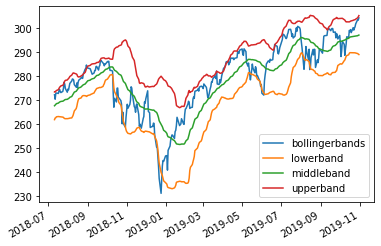

In [16]:
# QuantBook Analysis Tool 
# For more information see [https://www.quantconnect.com/docs/research/overview]
qb = QuantBook()
spy = qb.AddEquity("SPY")
history = qb.History(qb.Securities.Keys, 360, Resolution.Daily)

# Indicator Analysis
bbdf = qb.Indicator(BollingerBands(30, 2), spy.Symbol, 360, Resolution.Daily)
bbdf.drop('standarddeviation', 1).plot()

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression

class LinReg(QCAlgorithm):     
    
    def Initialize(self):
        self.SetStartDate(2013, 1, 1)  # Set Start Date
        self.SetEndDate(2019, 1, 1) # Set End Date
        
        self.lookback = 30 # number of previous days for training
        
        self.SetCash(100000)  # Set Strategy Cash
        spy = self.AddEquity("SPY", Resolution.Minute)
        
        self.symbols = [ spy.Symbol ] # In the future, we can include more symbols to the list in this way
        
        self.Schedule.On(self.DateRules.EveryDay("SPY"), self.TimeRules.AfterMarketOpen("SPY", 28), self.Regression)
        self.Schedule.On(self.DateRules.EveryDay("SPY"), self.TimeRules.AfterMarketOpen("SPY", 30), self.Trade)
        
    
    def Regression(self):
        # Daily historical data is used to train the machine learning model
        history = self.History(self.symbols, self.lookback, Resolution.Daily)

        # price dictionary:    key: symbol; value: historical price
        self.prices = {}
        # slope dictionary:    key: symbol; value: slope
        self.slopes = {}
        
        for symbol in self.symbols:
            if not history.empty:
                # get historical open price
                self.prices[symbol] = list(history.loc[symbol.Value]['open'])

        # A is the design matrix
        A = range(self.lookback + 1)
        
        for symbol in self.symbols:
            if symbol in self.prices:
                # response
                Y = self.prices[symbol]
                # features
                X = np.column_stack([np.ones(len(A)), A])
                
                # data preparation
                length = min(len(X), len(Y))
                X = X[-length:]
                Y = Y[-length:]
                A = A[-length:]
                
                # fit the linear regression
                reg = LinearRegression().fit(X, Y)
                
                # run linear regression y = ax + b
                b = reg.intercept_
                a = reg.coef_[1]
                
                # store slopes for symbols
                self.slopes[symbol] = a/b
#                 self.plot("Regression",self.slopes)

In [19]:
# lr = LinReg()
# lr.Regression()
# history.plot()


AttributeError: 'LinReg' object has no attribute 'symbols'

In [8]:
from sklearn.linear_model import LinearRegression

qb = QuantBook()
# spy = qb.AddEquity("SPY")
ibm = qb.AddEquity("IBM")
history = qb.History(qb.Securities.Keys, datetime(1998, 12, 11), datetime(2018, 12, 12), Resolution.Daily)
trainPrices = history[['close']][:int(len(history)/2)]
testPrices = history[['close']][int(len(history)/2):]

#bbdf = qb.Indicator(BollingerBands(30, 2), spy.Symbol, 360, Resolution.Daily)
#bbdf.drop('standarddeviation', 1).plot()

print(history.shape)
#history.head()
prices = history[['close']]
#prices.plot()

lookback = 100;
pastPriceRolling = trainPrices.rolling(lookback, win_type='triang').sum().iloc[2*lookback:]/25
futurePriceRolling = trainPrices.rolling(lookback, win_type='triang').sum().iloc[lookback:-lookback]/25
pastPriceRolling.plot()
futurePriceRolling.plot()
reg = LinearRegression().fit(pastPriceRolling, futurePriceRolling)

prediction = reg.predict(testPrices)

#plt.plot(pastPriceRolling.values)
plt.plot(prediction)
plt.plot(testPrices.values)
plt.show()

(5032, 5)


AttributeError: 'Window' object has no attribute 'diff'

(461, 5)
                      close
symbol time                
IBM 2T 2018-01-17  0.628128
       2018-01-18  4.313758
       2018-01-19  0.609653
       2018-01-20 -6.262801
       2018-01-23  0.221692
[[0.06213544]]
[-0.05910861]


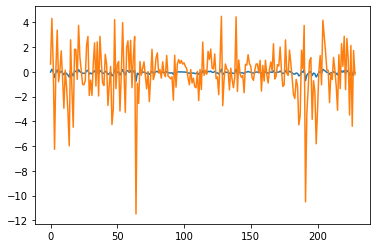

In [14]:
from sklearn.linear_model import LinearRegression

qb = QuantBook()
#spy = qb.AddEquity("SPY")
ibm = qb.AddEquity("IBM")
history = qb.History(qb.Securities.Keys, datetime(2017, 2, 11), datetime(2018, 12, 12), Resolution.Daily)
trainPrices = history[['close']][:int(len(history)/2)]
testPrices = history[['close']][int(len(history)/2):]

print(history.shape)
#history.head()
#prices.plot()

lookback = 30;

trainPrices = trainPrices.diff().iloc[2:]
testPrices = testPrices.diff().iloc[2:]
print(testPrices.head())

futurePriceRolling = trainPrices.rolling(lookback, win_type='triang').sum().iloc[2*lookback:]/5
presentPriceRolling = trainPrices.rolling(lookback, win_type='triang').sum().iloc[lookback:-lookback]/5
#presentPriceRolling.plot()
#futurePriceRolling.plot()
reg = LinearRegression().fit(presentPriceRolling, futurePriceRolling)

prediction = reg.predict(testPrices)
print(reg.coef_)
print(reg.intercept_)

plt.plot(prediction)
plt.plot(testPrices.values)
plt.show()